<a href="https://colab.research.google.com/github/usshaa/Colabnb/blob/main/Langraph_Multiagent_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Use Case: Multi-Agent GitHub Project Recommender

---

### System Overview

* **User Input**: Keywords like "chatbot", "sentiment analysis", etc.
* **Search Agent**: Uses Tavily or a tool to fetch GitHub links related to the keyword.
* **Filter Agent**: Uses Gemini to filter useful projects.
* **Summarizer Agent**: Uses Gemini to summarize & recommend top ones.

---

### Step 1: Install Dependencies

In [3]:
!pip install langgraph langchain tavily-python langchain-google-genai langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.1 MB/s eta 0:00:00


### Step 3: Build Agent

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from google.colab import userdata
from langchain_community.tools.tavily_search import TavilySearchResults

In [5]:
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
if not GOOGLE_API_KEY:
  raise ValueError("Please set your GOOGLE_API_KEY in Colab Secrets")

In [6]:
# Choose a model that supports chat, e.g., 'gemini-1.5-flash-latest' or 'gemini-1.5-pro-latest'
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", google_api_key=GOOGLE_API_KEY)

In [7]:
search = TavilySearchResults(max_results=5,tavily_api_key = TAVILY_API_KEY)

/tmp/ipython-input-7-255552966.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search = TavilySearchResults(max_results=5,tavily_api_key = TAVILY_API_KEY)


In [8]:
# Node 1: Search GitHub Repos via Tavily
def search_agent(state):
    keyword = state['keyword']
    results = search.run(f"site:github.com {keyword} project repo")
    state['raw_results'] = results
    return state

In [9]:
# Node 2: Filter GitHub links using Gemini
def filter_agent(state):
    raw = state['raw_results']
    raw_text = "\n".join([r["title"] + ": " + r["url"] for r in raw])
    prompt = f"""Here are some GitHub repo search results for '{state['keyword']}'.
    Please select and list only the most relevant repos:

    {raw_text}
    """
    filtered = llm.invoke(prompt)
    state['filtered_results'] = filtered.content
    return state

In [10]:
# Node 3: Summarize and Recommend
def summary_agent(state):
    prompt = f"""You are a GitHub assistant. Based on these filtered results, write a brief, clear recommendation to the user:

    {state['filtered_results']}
    """
    summary = llm.invoke(prompt)
    state['recommendation'] = summary.content
    return state

In [11]:
# LangGraph flow
builder = StateGraph(dict)
builder.add_node("search", search_agent)
builder.add_node("filter", filter_agent)
builder.add_node("summarize", summary_agent)

In [12]:
builder.set_entry_point("search")
builder.add_edge("search", "filter")
builder.add_edge("filter", "summarize")
builder.add_edge("summarize", END)

In [13]:
app = builder.compile()

### Step 4: Run It

In [ ]:
if __name__ == "__main__":
    query = input("Enter keyword(s) to find GitHub projects: ")
    result = app.invoke({"keyword": query})
    print("\nGemini Recommendation:")
    print(result['recommendation'])

Enter keyword(s) to find GitHub projects: Chatbot using gemini

Gemini Recommendation:
For Gemini-based chatbot projects, check out `tommanzur/chat-bot-gemini`, `FareedKhan-dev/Gemini-AI-chatbot`, `aayushai/Google-Gemini-Chatbot`, and  `Tahrim19/chatbot` (which uses the Google Gemini API).


### 🔄 Agents Recap

| Agent Name      | Purpose                                       |
| --------------- | --------------------------------------------- |
| `search_agent`  | Fetch GitHub links from search engine         |
| `filter_agent`  | Use Gemini LLM to pick relevant repos         |
| `summary_agent` | Use Gemini LLM to write user-friendly summary |

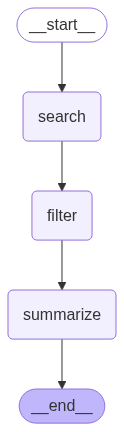

In [14]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))